## Rod Control Example

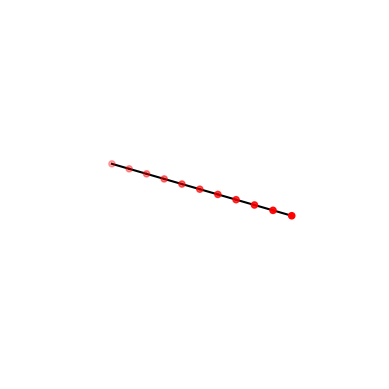

In [1]:
import numpy as np
import time
import dismech

geom = dismech.GeomParams(
    rod_r0=2e-2,
    shell_h=0.0,
)

material = dismech.Material(density=2000,
                            youngs_rod=1e3,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

dynamic_2d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=True,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-3,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
env.add_force('damping', eta=10)
env.set_static()

geo = dismech.Geometry.from_txt(
    '../tests/resources/rod_cantilever/horizontal_rod_n11.txt')

robot = dismech.SoftRobot(geom, material, geo, dynamic_2d_sim, env)

In [2]:
fixed_points = np.array([0, 10]) # Fix the first and last node

robot = robot.fix_nodes(fixed_points)
stepper = dismech.ImplicitEulerTimeStepper(robot)

### Time Stepping
PID Control

In [3]:
nodes_negative_g = np.array([6,7,8,9,10])
robot.scale_mass_matrix(nodes=nodes_negative_g, scale=-1.0)
robot.scale_mass_matrix(nodes=5, scale=0.0)  # make node 5 massless
print(robot.mass_matrix)

[ 1.25663706e-02  1.25663706e-02  1.25663706e-02  2.51327412e-02
  2.51327412e-02  2.51327412e-02  2.51327412e-02  2.51327412e-02
  2.51327412e-02  2.51327412e-02  2.51327412e-02  2.51327412e-02
  2.51327412e-02  2.51327412e-02  2.51327412e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.51327412e-02 -2.51327412e-02
 -2.51327412e-02 -2.51327412e-02 -2.51327412e-02 -2.51327412e-02
 -2.51327412e-02 -2.51327412e-02 -2.51327412e-02 -2.51327412e-02
 -2.51327412e-02 -2.51327412e-02 -1.25663706e-02 -1.25663706e-02
 -1.25663706e-02  5.02654825e-06  5.02654825e-06  5.02654825e-06
  5.02654825e-06  5.02654825e-06  5.02654825e-06  5.02654825e-06
  5.02654825e-06  5.02654825e-06  5.02654825e-06]


In [4]:

def before_step_fn(rb, t):
    
    # update gravity slowly
    rb.env.g = rb.env.static_g * t / rb.sim_params.total_time

    return rb


In [5]:

stepper.before_step = before_step_fn
robots = stepper.simulate()

# stack initial q first with all other
qs0 = robot.state.q[np.newaxis, :]
robot0 = robot
qs_other = np.stack([robot.state.q for robot in robots])
qs = np.vstack([qs0, qs_other])

robots = [robot0] + robots # include the initial robot


iter: 1, error: 0.001
current_time:  0.001
iter: 1, error: 0.001
current_time:  0.002
iter: 1, error: 0.002
current_time:  0.003
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.004
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.005
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.006
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.007
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.008
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.009000000000000001
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.01
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.011
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.012
iter: 1, error: 0.002
iter: 2, error: 0.000
current_time:  0.013000000000000001
iter: 1, error: 0.003
iter: 2, error: 0.000
current_time:  0.014
iter: 1, error: 0.003
iter: 2, error: 0.000
current_time:  0.015
iter: 1, error: 0.003
iter: 2, error: 0.000
current_time:  0.0

In [6]:
t = np.linspace(0, dynamic_2d_sim.total_time, qs.shape[0])
options = dismech.AnimationOptions(title='Rod PID', plot_step=100)

fig = dismech.get_interactive_animation_plotly(robot, t, qs, options)
fig.show()

In [7]:
from dismech.logging import logDataForRendering
t=t[::1]
rod_data, shell_data = logDataForRendering(qs, t.reshape(-1, 1), robot, len(t), False, robot.map_node_to_dof)

from dismech.logging import export_rod_shell_data
export_rod_shell_data(robot, rod_file='rawDataRod.txt', shell_file='rawDataShell.txt',
                          rod_js='rodData.js', shell_js='shellData.js',
                          rod_radius=0.7, scaleFactor=400)

(1001, 44) (1001, 1) (1001, 43)
(0,)
0


/home/radha/Desktop/PhD/dismech-python/dismech-python/src/dismech/logging.py:100: UserWarning:

loadtxt: input contained no data: "rawDataShell.txt"



In [8]:
import json
import numpy as np

def save_robot_state_to_json(state, filename="final_state.json"):
    """
    Save the entire RobotState object to a JSON file.
    Automatically converts numpy arrays to lists.
    """
    state_dict = {}
    
    # loop through all attributes of the state
    for attr in dir(state):
        # skip private attributes and methods
        if attr.startswith("_"):
            continue
        val = getattr(state, attr)
        
        # skip callables (methods, properties that are functions)
        if callable(val):
            continue
        
        # convert numpy arrays to lists for JSON serialization
        if isinstance(val, np.ndarray):
            state_dict[attr] = val.tolist()
        else:
            # handle nested numpy arrays or None/float/int
            try:
                json.dumps(val)  # test if JSON serializable
                state_dict[attr] = val
            except TypeError:
                # fallback for unknown types (e.g., other custom objects)
                state_dict[attr] = str(val)

    # write to JSON
    with open(filename, "w") as f:
        json.dump(state_dict, f, indent=2)

# --- usage ---
final_state = robots[-1].state
save_robot_state_to_json(final_state, "final_state_new.json")
print("Saved full state to final_state_new.json")


Saved full state to final_state_new.json
